In [ ]:
import os
import numpy as np
import shutil
import random
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = os.path.join('/content/drive/MyDrive/gdrive/Computer_vision_engineer_task/Computer Vision Engineer Task/dataset')

In [ ]:
os.listdir(data)

['Mask', 'Image', 'train', 'valid']

In [ ]:
os.makedirs(os.path.join(data, 'train','Images'), exist_ok=True)
os.makedirs(os.path.join(data, 'train','Mask'), exist_ok=True)

In [ ]:
os.makedirs(os.path.join(data, 'valid','Images'), exist_ok=True)
os.makedirs(os.path.join(data, 'valid','Mask'), exist_ok=True)

In [ ]:
train_dir = os.path.join(data, 'train')
valid_dir = os.path.join(data, 'valid')

In [ ]:
print(train_dir)
print(valid_dir)

/content/drive/MyDrive/gdrive/Computer_vision_engineer_task/Computer Vision Engineer Task/dataset/train
/content/drive/MyDrive/gdrive/Computer_vision_engineer_task/Computer Vision Engineer Task/dataset/valid


In [ ]:
os.listdir(data)

['Mask', 'Image', 'train', 'valid']

In [ ]:
image_files = os.listdir(os.path.join(data, 'Image'))

In [ ]:
len(image_files)

20

In [ ]:
random.shuffle(image_files)

In [ ]:
train_size = len(image_files) - 5
valid_size = 5

In [ ]:
valid_size

5

In [ ]:
train_files = image_files[:train_size]
valid_files = image_files[train_size:]

In [ ]:
for files in train_files:
    image_src = os.path.join(data,'Image', files)
    mask_src = os.path.join(data,'Mask', files.split('.')[0] + '.png')
    shutil.copy(image_src, os.path.join(train_dir, 'Images', files))
    shutil.copy(mask_src, os.path.join(train_dir, 'Mask', files.split('.')[0] + '.png'))

In [ ]:
for files in valid_files:
    image_src = os.path.join(data,'Image', files)
    mask_src = os.path.join(data,'Mask', files.split('.')[0] + '.png')
    shutil.copy(image_src, os.path.join(valid_dir, 'Images', files))
    shutil.copy(mask_src, os.path.join(valid_dir, 'Mask', files.split('.')[0] + '.png'))

In [ ]:
H = 320
W = 320

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Add
from tensorflow.keras import losses

def conv_block(inputs, out_ch, rate=1):
    x = Conv2D(out_ch, 3, padding="same", dilation_rate=1)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def RSU_L(inputs, out_ch, int_ch, num_layers, rate=2):
    """ Initial Conv """
    x = conv_block(inputs, out_ch)
    init_feats = x

    """ Encoder """
    skip = []
    x = conv_block(x, int_ch)
    skip.append(x)

    for i in range(num_layers-2):
        x = MaxPool2D((2, 2))(x)
        x = conv_block(x, int_ch)
        skip.append(x)

    """ Bridge """
    x = conv_block(x, int_ch, rate=rate)

    """ Decoder """
    skip.reverse()

    x = Concatenate()([x, skip[0]])
    x = conv_block(x, int_ch)

    for i in range(num_layers-3):
        x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
        x = Concatenate()([x, skip[i+1]])
        x = conv_block(x, int_ch)

    x = UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = Concatenate()([x, skip[-1]])
    x = conv_block(x, out_ch)

    """ Add """
    x = Add()([x, init_feats])
    return x

def RSU_4F(inputs, out_ch, int_ch):
    """ Initial Conv """
    x0 = conv_block(inputs, out_ch, rate=1)

    """ Encoder """
    x1 = conv_block(x0, int_ch, rate=1)
    x2 = conv_block(x1, int_ch, rate=2)
    x3 = conv_block(x2, int_ch, rate=4)

    """ Bridge """
    x4 = conv_block(x3, int_ch, rate=8)

    """ Decoder """
    x = Concatenate()([x4, x3])
    x = conv_block(x, int_ch, rate=4)

    x = Concatenate()([x, x2])
    x = conv_block(x, int_ch, rate=2)

    x = Concatenate()([x, x1])
    x = conv_block(x, out_ch, rate=1)

    """ Addition """
    x = Add()([x, x0])
    return x

def u2net(input_shape, out_ch, int_ch, num_classes=1):
    """ Input Layer """
    inputs = Input(input_shape)
    s0 = inputs

    """ Encoder """
    s1 = RSU_L(s0, out_ch[0], int_ch[0], 7)
    p1 = MaxPool2D((2, 2))(s1)

    s2 = RSU_L(p1, out_ch[1], int_ch[1], 6)
    p2 = MaxPool2D((2, 2))(s2)

    s3 = RSU_L(p2, out_ch[2], int_ch[2], 5)
    p3 = MaxPool2D((2, 2))(s3)

    s4 = RSU_L(p3, out_ch[3], int_ch[3], 4)
    p4 = MaxPool2D((2, 2))(s4)

    s5 = RSU_4F(p4, out_ch[4], int_ch[4])
    p5 = MaxPool2D((2, 2))(s5)

    """ Bridge """
    b1 = RSU_4F(p5, out_ch[5], int_ch[5])
    b2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(b1)

    """ Decoder """
    d1 = Concatenate()([b2, s5])
    d1 = RSU_4F(d1, out_ch[6], int_ch[6])
    u1 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d1)

    d2 = Concatenate()([u1, s4])
    d2 = RSU_L(d2, out_ch[7], int_ch[7], 4)
    u2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d2)

    d3 = Concatenate()([u2, s3])
    d3 = RSU_L(d3, out_ch[8], int_ch[8], 5)
    u3 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d3)

    d4 = Concatenate()([u3, s2])
    d4 = RSU_L(d4, out_ch[9], int_ch[9], 6)
    u4 = UpSampling2D(size=(2, 2), interpolation="bilinear")(d4)

    d5 = Concatenate()([u4, s1])
    d5 = RSU_L(d5, out_ch[10], int_ch[10], 7)

    """ Side Outputs """
    y1 = Conv2D(num_classes, 3, padding="same")(d5)

    y2 = Conv2D(num_classes, 3, padding="same")(d4)
    y2 = UpSampling2D(size=(2, 2), interpolation="bilinear")(y2)

    y3 = Conv2D(num_classes, 3, padding="same")(d3)
    y3 = UpSampling2D(size=(4, 4), interpolation="bilinear")(y3)

    y4 = Conv2D(num_classes, 3, padding="same")(d2)
    y4 = UpSampling2D(size=(8, 8), interpolation="bilinear")(y4)

    y5 = Conv2D(num_classes, 3, padding="same")(d1)
    y5 = UpSampling2D(size=(16, 16), interpolation="bilinear")(y5)

    y6 = Conv2D(num_classes, 3, padding="same")(b1)
    y6 = UpSampling2D(size=(32, 32), interpolation="bilinear")(y6)

    y0 = Concatenate()([y1, y2, y3, y4, y5, y6])
    y0 = Conv2D(num_classes, 3, padding="same")(y0)

    y0 = Activation("sigmoid", name="y0")(y0)
    y1 = Activation("sigmoid", name="y1")(y1)
    y2 = Activation("sigmoid", name="y2")(y2)
    y3 = Activation("sigmoid", name="y3")(y3)
    y4 = Activation("sigmoid", name="y4")(y4)
    y5 = Activation("sigmoid", name="y5")(y5)
    y6 = Activation("sigmoid", name="y6")(y6)

    model = tf.keras.models.Model(inputs, outputs=[y0, y1, y2, y3, y4, y5, y6])
    return model

def build_u2net(input_shape, num_classes=1):
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    int_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    model = u2net(input_shape, out_ch, int_ch, num_classes=num_classes)
    return model

def build_u2net_lite(input_shape, num_classes=1):
    out_ch = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
    int_ch = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    model = u2net(input_shape, out_ch, int_ch, num_classes=num_classes)
    return model

model = build_u2net((H, W, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 320, 320, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 320, 320, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 320, 320, 64)         0         ['batch_normalization[0][0

In [ ]:
from tensorflow.keras.metrics import MeanIoU

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    return 1 - ((2 * intersection + smooth) / union)

In [ ]:
def load_dataset(path):
    train_x = sorted(glob(os.path.join(path, "train", "Images", "*.jpg")))
    train_y = sorted(glob(os.path.join(path, "train", "Mask", "*.png")))

    valid_x = sorted(glob(os.path.join(path, "valid", "Images",  "*.jpg")))
    valid_y = sorted(glob(os.path.join(path, "valid", "Mask", "*.png")))

    return (train_x, train_y), (valid_x, valid_y)

In [ ]:
import cv2

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [ ]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

In [ ]:
def tf_dataset(X, Y, batch=2):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.map(tf_parse).batch(batch).prefetch(5)
    return ds

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
(xtrain, ytrain), (xvalid, yvalid) = load_dataset(data)

In [ ]:
train_dataset = tf_dataset(xtrain, ytrain, batch=2)
valid_dataset = tf_dataset(xvalid, yvalid, batch=2)

In [ ]:
# loss_function = tf.keras.losses.BinaryCrossentropy()
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
loss_function = losses.BinaryCrossentropy(from_logits=True)
iou_metric = MeanIoU(num_classes=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=iou_metric)

In [ ]:
num_epochs = 100
hist = model.fit(train_dataset, validation_data=valid_dataset, epochs=num_epochs)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 131s 2s/step - loss: 5.7236 - y0_loss: 1.3671 - y1_loss: 0.5773 - y2_loss: 0.5158 - y3_loss: 0.8235 - y4_loss: 0.7249 - y5_loss: 0.8286 - y6_loss: 0.8865 - y0_mean_io_u: 0.3659 - y1_mean_io_u: 0.3679 - y2_mean_io_u: 0.3679 - y3_mean_io_u: 0.3679 - y4_mean_io_u: 0.3679 - y5_mean_io_u: 0.3697 - y6_mean_io_u: 0.3679 - val_loss: 5684383744.0000 - val_y0_loss: 570033280.0000 - val_y1_loss: 2490565632.0000 - val_y2_loss: 1334700160.0000 - val_y3_loss: 337991392.0000 - val_y4_loss: 944493504.0000 - val_y5_loss: 6566432.0000 - val_y6_loss: 33818.2539 - val_y0_mean_io_u: 0.3790 - val_y1_mean_io_u: 0.3807 - val_y2_mean_io_u: 0.3790 - val_y3_mean_io_u: 0.1377 - val_y4_mean_io_u: 0.1305 - val_y5_mean_io_u: 0.3077 - val_y6_mean_io_u: 0.3286
Epoch 2/100
10/10 [==============================] - 3s 296ms/step - loss: 3.0163 - y0_loss: 0.7325 - y1_loss: 0.3333 - y2_loss: 0.3086 - y3_loss: 0.4159 - y4_loss: 0.3428 - y5_loss: 0.4354 - y6_loss: 0.4478 - y0_mean_io_

In [ ]:
os.chdir('/content/drive/MyDrive/gdrive/Computer_vision_engineer_task/Computer Vision Engineer Task/')

In [ ]:
model.save('u2net_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('u2net_model.h5')  # Replace with the path to your saved model file

In [ ]:
import requests
from PIL import Image
from io import BytesIO

In [ ]:
image_url = 'https://cdni.autocarindia.com/Utils/ImageResizer.ashx?n=https://cms.haymarketindia.net/model/uploads/modelimages/Hyundai-Grand-i10-Nios-200120231541.jpg&w=373&h=245&q=75&c=1'

In [ ]:
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

In [ ]:
def preprocess_image(image):
    image = image.resize((320, 320))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0
    image = tf.expand_dims(image, axis=0)
    return image

In [ ]:
input_image = preprocess_image(image)

output = model.predict(input_image)
output = np.array(output)


1/1 [==============================] - 0s 31ms/step


In [ ]:
output.shape

(7, 1, 320, 320, 1)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
output = np.squeeze(output, axis=1)
output = np.squeeze(output, axis=-1)

In [ ]:
threshold = 0.5
binary_mask = (output > threshold).astype(np.uint8)

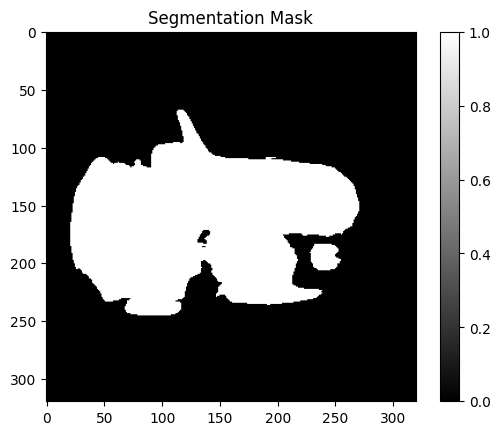

In [ ]:
plt.imshow(binary_mask[0], cmap='gray')  # Display the first prediction
plt.title("Segmentation Mask")
plt.colorbar()
plt.show()